## Load packages

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'
import numpy as np
import seaborn as sns

## Specify filepaths

In [16]:
source_plate = 'data/20221213_plate.xlsx'
plate_data = 'data/20221216_medium_conditioning.xlsx'
graph_outpath = 'graphs/'

In [17]:
plate_df = pd.read_excel(source_plate, header=0)
plate_df.head(5)

,well,condition,strain,conditioning_mutant,inoculum,replicate
0,B2,control,LL13-040,FCY1,FUR1,1
1,C2,control,LL13-040,FCY1,FUR1,2
2,D2,control,LL13-040,FCY1,FUR1,3
3,E2,control,NC-02,FCY1,FUR1,1
4,F2,control,NC-02,FCY1,FUR1,2


## Get plate reader data

In [18]:
def get_data(fpath):
    source_df = pd.read_excel(fpath, header=1, index_col=0,skiprows=[2],skipfooter=34)
    source_df.rename(columns=lambda x: float(x.strip('s'))/3600, inplace=True)
    longdf = source_df.reset_index().rename(columns = {'index' : 'well'})
    longdf = longdf.melt(id_vars = ['well'], var_name = 'time (h)', value_name = 'OD') # wide to long dataframe
    return longdf

In [19]:
df = get_data(plate_data)
df

,well,time (h),OD
0,B2,0.0,0.105670
1,B3,0.0,0.110780
2,B4,0.0,0.106630
3,B5,0.0,0.110380
4,B6,0.0,0.107130
...,...,...,...
16615,G7,69.009167,0.451720
16616,G8,69.009167,0.591050
16617,G9,69.009167,0.540650
16618,G10,69.009167,0.080600


In [20]:
merged = df.merge(right=plate_df, on=['well'])
merged

,well,time (h),OD,condition,strain,conditioning_mutant,inoculum,replicate
0,B2,0.0,0.10567,control,LL13-040,FCY1,FUR1,1
1,B2,0.25,0.11008,control,LL13-040,FCY1,FUR1,1
2,B2,0.5,0.11028,control,LL13-040,FCY1,FUR1,1
3,B2,0.75,0.11003,control,LL13-040,FCY1,FUR1,1
4,B2,1.0,0.10992,control,LL13-040,FCY1,FUR1,1
...,...,...,...,...,...,...,...,...
13291,G9,68.008889,0.53515,5-FC,NC-02,FUR1,WT,3
13292,G9,68.258889,0.53620,5-FC,NC-02,FUR1,WT,3
13293,G9,68.509167,0.53800,5-FC,NC-02,FUR1,WT,3
13294,G9,68.759167,0.53947,5-FC,NC-02,FUR1,WT,3


## Visualize growth curves

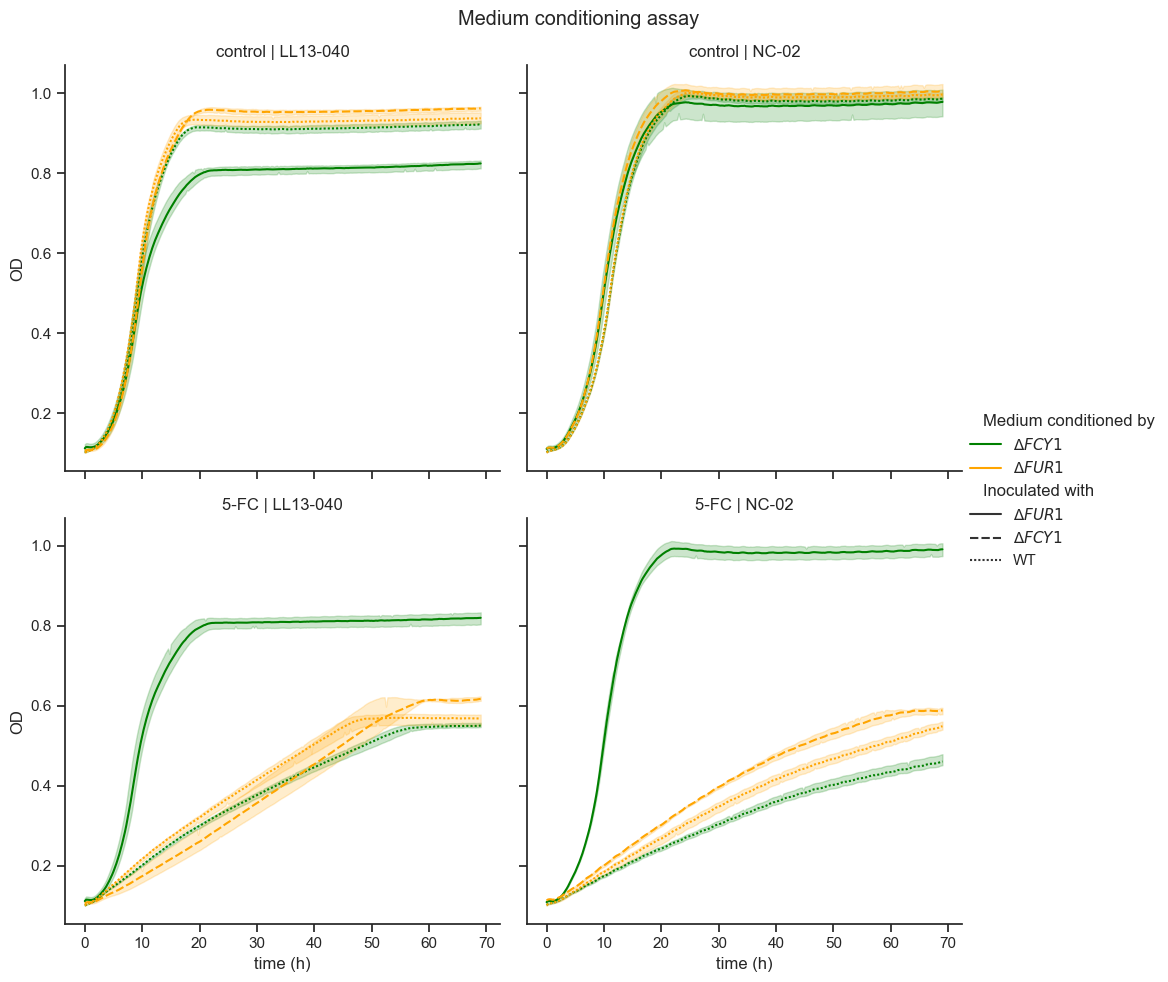

In [8]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
grid = sns.relplot(data=merged, x='time (h)', y='OD', row='condition', col = 'strain', hue='conditioning_mutant', hue_order=['FCY1','FUR1'], palette=['green','orange'], style='inoculum', style_order=['FUR1','FCY1','WT'], kind='line')
grid.set_titles(row_template='{row_name}', col_template='{col_name}')
grid.set_axis_labels('time (h)', 'OD')
for i, v in enumerate(['Medium conditioned by', u'Δ$\it{FCY1}$', u'Δ$\it{FUR1}$', 'Inoculated with', u'Δ$\it{FUR1}$', u'Δ$\it{FCY1}$', 'WT']):
    grid._legend.texts[i].set_text(v)
grid.fig.subplots_adjust(top=0.9)
plt.suptitle('Medium conditioning assay')
grid.tight_layout()
#plt.savefig(graph_outpath+'20221216_medium_conditioning.svg', format='svg', dpi=300)
#plt.savefig(graph_outpath+'20221216_medium_conditioning.png', format='png', dpi=300)

## Calculate normalized area under the curve (AUC)

In [21]:
from flucytosine_functions import get_auc
aucdf = merged.groupby(['condition','strain','conditioning_mutant','inoculum','well', 'replicate'])[['OD']].apply(func=get_auc).reset_index(name='auc')
aucdf.head(6)

,condition,strain,conditioning_mutant,inoculum,well,replicate,auc
0,5-FC,LL13-040,FCY1,FUR1,B6,1,195.773365
1,5-FC,LL13-040,FCY1,FUR1,C6,2,191.754260
2,5-FC,LL13-040,FCY1,FUR1,D6,3,201.920900
3,5-FC,LL13-040,FCY1,WT,B7,1,108.265990
4,5-FC,LL13-040,FCY1,WT,C7,2,104.590630
5,5-FC,LL13-040,FCY1,WT,D7,3,106.479760


In [22]:
def get_norm_auc(df, lc, well):
    well_val = df.loc[df.well==well, 'auc'].values[0]
    well_set = df.loc[df.well==well, lc[:-1]].values[0].tolist()
    well_set.append('WT')
    wt_val = df.loc[df[lc].isin(well_set).all(1), 'auc'].values[0]
    return well_val/wt_val

In [23]:
list_conditions = ['condition', 'strain', 'conditioning_mutant', 'replicate', 'inoculum']
aucdf['norm_auc'] = aucdf.apply(lambda row: get_norm_auc(aucdf, list_conditions, row.well), axis=1)
aucdf.head(6)

,condition,strain,conditioning_mutant,inoculum,well,replicate,auc,norm_auc
0,5-FC,LL13-040,FCY1,FUR1,B6,1,195.773365,1.808263
1,5-FC,LL13-040,FCY1,FUR1,C6,2,191.754260,1.833379
2,5-FC,LL13-040,FCY1,FUR1,D6,3,201.920900,1.896331
3,5-FC,LL13-040,FCY1,WT,B7,1,108.265990,1.000000
4,5-FC,LL13-040,FCY1,WT,C7,2,104.590630,1.000000
5,5-FC,LL13-040,FCY1,WT,D7,3,106.479760,1.000000


In [24]:
aucdf.drop(aucdf[aucdf.inoculum == 'WT'].index, inplace=True)
aucdf.head(6)

,condition,strain,conditioning_mutant,inoculum,well,replicate,auc,norm_auc
0,5-FC,LL13-040,FCY1,FUR1,B6,1,195.773365,1.808263
1,5-FC,LL13-040,FCY1,FUR1,C6,2,191.754260,1.833379
2,5-FC,LL13-040,FCY1,FUR1,D6,3,201.920900,1.896331
6,5-FC,LL13-040,FUR1,FCY1,B8,1,103.186260,0.882645
7,5-FC,LL13-040,FUR1,FCY1,C8,2,104.516980,0.940250
8,5-FC,LL13-040,FUR1,FCY1,D8,3,117.729210,1.001923


## Perform ANOVA

In [25]:
from flucytosine_functions import get_Tukey

In [26]:
aucdf['factor'] = aucdf.groupby(['strain', 'conditioning_mutant', 'inoculum'], sort=False).ngroup().astype(str).str.cat([aucdf.strain, aucdf.conditioning_mutant], sep='_')
aucdf.head(6)

,condition,strain,conditioning_mutant,inoculum,well,replicate,auc,norm_auc,factor
0,5-FC,LL13-040,FCY1,FUR1,B6,1,195.773365,1.808263,0_LL13-040_FCY1
1,5-FC,LL13-040,FCY1,FUR1,C6,2,191.754260,1.833379,0_LL13-040_FCY1
2,5-FC,LL13-040,FCY1,FUR1,D6,3,201.920900,1.896331,0_LL13-040_FCY1
6,5-FC,LL13-040,FUR1,FCY1,B8,1,103.186260,0.882645,1_LL13-040_FUR1
7,5-FC,LL13-040,FUR1,FCY1,C8,2,104.516980,0.940250,1_LL13-040_FUR1
8,5-FC,LL13-040,FUR1,FCY1,D8,3,117.729210,1.001923,1_LL13-040_FUR1


In [27]:
get_Tukey(aucdf, 'condition', 'factor', 'norm_auc')[1]

C:\Users\duran\OneDrive - Université Laval\Notebooks\ASUS_notebooks\flucytosine_functions.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anova_df['combination'] = anova_df.apply(lambda row: str(row[factor1])+' / '+str(row[factor2]), axis=1)


,condition1,group1,group2,p-adj,reject,stat_significance
3,0_LL13-040_FCY1,5-FC / 0_LL13-040_FCY1,control / 0_LL13-040_FCY1,0.0000,True,****
10,1_LL13-040_FUR1,5-FC / 1_LL13-040_FUR1,control / 1_LL13-040_FUR1,0.7106,False,ns
16,2_NC-02_FCY1,5-FC / 2_NC-02_FCY1,control / 2_NC-02_FCY1,0.0000,True,****
21,3_NC-02_FUR1,5-FC / 3_NC-02_FUR1,control / 3_NC-02_FUR1,0.3181,False,ns


C:\Users\duran\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\seaborn\utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


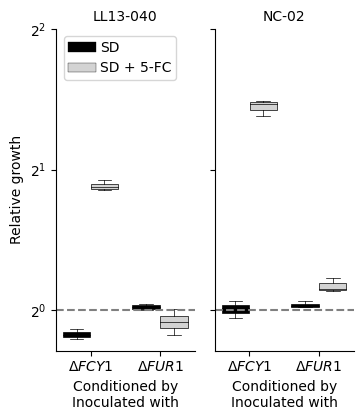

In [34]:
grid = sns.catplot(data=aucdf[aucdf.inoculum != 'WT'], x='conditioning_mutant', y='norm_auc',
                   col='strain', col_order=['LL13-040', 'NC-02'],
                   hue='condition', hue_order=['control', '5-FC'], palette=['black','lightgrey'],
                   kind='box', dodge=True,
                   linewidth=0.5,
                   height=4.3, aspect=0.44 # height*aspect = width of EACH facet
                  )
plt.yscale('log', base=2)
grid.map(plt.axhline, y=1, ls='--', c='grey')
grid.set_titles(col_template='{col_name}')
grid.set_axis_labels('Conditioned by\nInoculated with', 'Relative growth')
grid.set(xticklabels=[u'Δ$\it{FCY1}$', u'Δ$\it{FUR1}$'], ylim=(None,4))

handles, labels = grid.axes[0][0].get_legend_handles_labels()
sns.move_legend(grid, bbox_to_anchor=(0.13, 0.92), loc='upper left', title=None, frameon=True, handles=handles, labels=['SD','SD + 5-FC'], handletextpad=0.3, borderpad=0.3)

grid.tight_layout()
plt.savefig(graph_outpath+'20230404_medium_conditioning.svg', format='svg', dpi=300)
plt.savefig(graph_outpath+'20230404_medium_conditioning.png', format='png', dpi=300)